In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

import json
import time
import itertools as it
import sys
sys.path.append('lib')
from analysis_utils import *

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

# Todo 
- make PR_type a string for all versions

In [10]:
def combine(*vs):
    def loop():
        first_pid = 0
        for v in vs:
            df = pd.read_csv('data/human/0.{}/mouselab-mdp.csv'.format(v))
            pdf = pd.read_csv('data/human/0.{}/participants.csv'.format(v))
            df.pid += first_pid
            pdf.pid += first_pid
            first_pid += max(pdf.pid.max(), df.pid.max()) + 1
            yield df, pdf
    dfs, pdfs = zip(*loop())
    df = pd.concat(dfs).reset_index()
    pdf = pd.concat(pdfs).reset_index().set_index('pid', drop=False)
    return df, pdf

def load(v):
    df = pd.read_csv('data/human/{}/mouselab-mdp.csv'.format(v))
    pdf = pd.read_csv('data/human/{}/participants.csv'.format(v))
    return df, pdf

VERSION = '1B.1'
df, pdf = load(VERSION)

completed = list(pdf.query('completed').pid)
df = df.query('pid == @completed')
pdf = pdf.query('pid == @completed')

df.trial_index = df.trial_index.astype(int)
df.trial_i = df.trial_i.astype(int)
df['version'] = list(pdf.version.loc[df.pid])
df['info_cost'] = list(pdf.info_cost.loc[df.pid])
df['PR_type'] = list(pdf.PR_type.loc[df.pid])
df['message'] = list(pdf.message.loc[df.pid])


from toolz.curried import *
from ast import literal_eval
df.queries = df.queries.apply(literal_eval)
df['clicks'] = df.queries.apply(
    lambda x: lmap(int, x['click']['state']['target'])
)
df['click_times'] = df.queries.apply(
    lambda x: x['click']['state']['time']
)
df.action_times = df.action_times.apply(literal_eval)
df['n_click'] = df.clicks.apply(len)
df.delays = df.delays.apply(literal_eval)
df.path = df.path.apply(
    lambda x: [1] + literal_eval(x)[1:])

pdf['time'] = df.groupby('pid').time_elapsed.max() / 60000
pdf['score'] = df.groupby('pid').score.sum()
df.actions = df.actions.apply(literal_eval)

In [3]:

DEBUG = []
def parse_row(row):
    times = row.action_times + row.click_times
    acts = row.actions + row.clicks
    try:
        sorted_acts = np.array(acts)[np.argsort(times)]
    except:
        DEBUG.append(row)
        return None
    for a in sorted_acts:
        try:
            state = int(a)
        except:
            state = None
        yield {'is_click': state is not None,
               'move': a if state is None else None,
               'state': state}
        
from analysis_utils import *

for pid, dd in df.groupby('pid'):
    cond = pdf.condition[pid]
    dd = dd.sort_values('trial_i')
    # trace = list(filter(None, rowapply(dd, compose(list, parse_row))))
    trace = list(rowapply(dd, compose(list, parse_row)))
    path = 'data/human/{}/traces/{}/'.format(VERSION, cond)
    os.makedirs(path, exist_ok=True)
    with open(path + '{}.json'.format(pid), 'w+') as f:
        json.dump(trace, f)

In [6]:
df = df.drop(df[df.click_times.apply(lambda x: None in x)].index)
def click_then_move(row):
    return max(row.click_times, default=-1) < min(row.action_times)

np.mean(rowapply(df, click_then_move))

0.72044573643410847

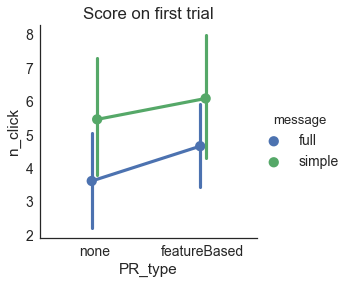

In [6]:
sns.factorplot('PR_type', 'n_click', hue='message', 
               data=df.query('trial_index == 1'),
               dodge=True)
plt.title('Score on first trial')

In [8]:
df.query('PR_type == "featureBased"').groupby('info_cost').delays.apply(
    lambda ds: np.stack(ds).mean(0).round().astype(int)
)

ValueError: need at least one array to stack

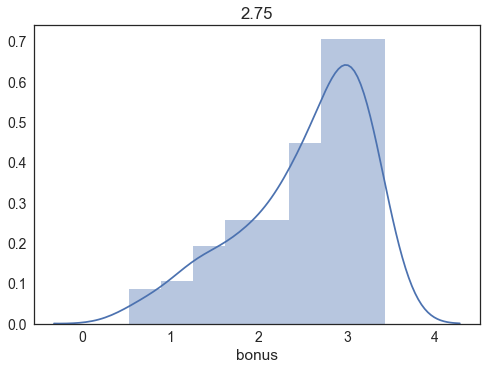

In [11]:
sns.distplot(pdf.bonus)
plt.title(pdf.bonus.median())

In [12]:
sys.path.append('bin')
from compensation import Compensator
comp = Compensator()
identifiers = pd.read_csv('data/human_raw/{}/identifiers.csv'.format(VERSION))
pdf = pd.read_csv('data/human/{}/participants.csv'.format(VERSION))
pdf = pdf.join(identifiers.set_index('pid'))
for i, row in pdf.iterrows():
    comp.approve(row.assignment_id)
    if row.bonus > 0:
        comp.grant_bonus(row.worker_id, row.assignment_id, round(row.bonus, 2))

Compensator: Approved assignment 3YOH7BII097S091VIWGYDU7JMFMVKJ
Compensator: Bonused $3.33 to worker A10ZKWRZ8WL775
Compensator: Error approving 3DI28L7YXAE9SXTNFWL68BNYEGPE14
Compensator: Approved assignment 3R5F3LQFV2KSZKRKHLXU5H1OUVZOZT
Compensator: Bonused $3.27 to worker A112V6HAH568DI
Compensator: Approved assignment 3EKVH9QMEY4BPCXJ25A07CFI6AWD2L
Compensator: Bonused $2.75 to worker A11ASDVMEEIYZE
Compensator: Approved assignment 3R5F3LQFV2KSZKRKHLXU5H1OUU4OZW
Compensator: Bonused $2.44 to worker A11WXSQQRJGQDR
Compensator: Approved assignment 3R0T90IZ1SCRZEZC1O0EPAR1URDGCQ
Compensator: Bonused $2.24 to worker A12WRJ2ZMDW3SU
Compensator: Approved assignment 3EA3QWIZ4IVMHM7IDYV7ZW4LYSFTIT
Compensator: Bonused $1.5 to worker A136WVBAZDIVLZ
Compensator: Error approving 3N4BPTXIO8SSNUCVD66TH850889UKP
Compensator: Approved assignment 3I3WADAZ9Q4US67VAXQEGDUTUYSO5S
Compensator: Bonused $1.17 to worker A16AFSPBIJC9CA
Compensator: Approved assignment 373ERPL3YO8ZALA13LPGDO5CLO1TR0
Compe

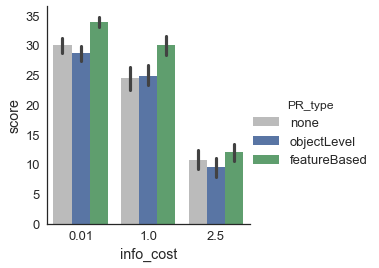

In [39]:
PALETTE = ['#bbbbbb'] + sns.palettes.SEABORN_PALETTES['deep']
sns.set_palette(PALETTE)
PR_ORDER = 'none objectLevel featureBased'.split()
# PR_ORDER = ['objectLevel', 'featureBased']

sns.factorplot('info_cost', 'score', hue='PR_type', data=df, 
               kind='bar', hue_order=PR_ORDER)

In [80]:
def comparison(kind):
    comp = pd.read_csv('data/stimuli/exp1/{}.csv'.format(kind), header=None)
    comp.columns = INFO_COSTS
    return comp
    return comp.stack()
    return comp.stack()[df[['trial_i', 'info_cost']].as_matrix()]

c = comparison('optimal')

(0, 5000)

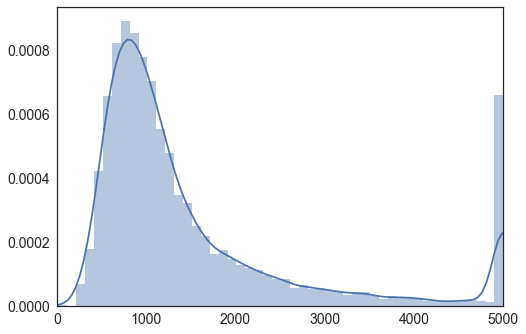

In [37]:
sns.distplot(np.concatenate(list(df.click_times.apply(np.diff))).clip(0, 5000))

In [17]:
INFO_COSTS = [0.01, 1.00, 2.50]
# INFO_COSTS = pdf.info_cost.unique()
dd = df.copy()
def comparison(kind):
    comp = pd.read_csv('data/stimuli/exp1/{}.csv'.format(kind), header=None)
    comp.columns = INFO_COSTS
    return list(comp[1.0].loc[df.trial_i])
    return comp.stack()[df[['trial_i', 'info_cost']].as_matrix()]

df['optimal'] = comparison('optimal')
df['worst'] = comparison('worst')

# df['optimal'] = list(optimal.loc[df.trial_i])
df['regret'] = df.score - df.optimal
df['trial_mean'] = list(df.groupby('trial_i').score.mean().loc[df.trial_i])
df['centered_score'] = df.score - df.trial_mean

# (R-R_min)/(R_max-R_min)
df['relative_score'] = (df.score - df.worst) / (df.optimal - df.worst)

In [20]:
cols = ('pid info_cost PR_type message trial_index trial_i delays '
        'score n_click clicks click_times path action_times'
        .split())
df[cols].to_csv('data/human/1B.1/trials.csv')

In [103]:
df['condition'] = pdf.PR_type.apply(lambda x: 'constant' if x == 'none' else 'pseudo') + '_' + pdf.message

In [156]:
sns.lmplot('trial_index', 'score', hue='message', col='PR_type', data=df,
           size=4, sharey=True, lowess=True, scatter=0)

TypeError: lmplot() got an unexpected keyword argument 'hue_kws'

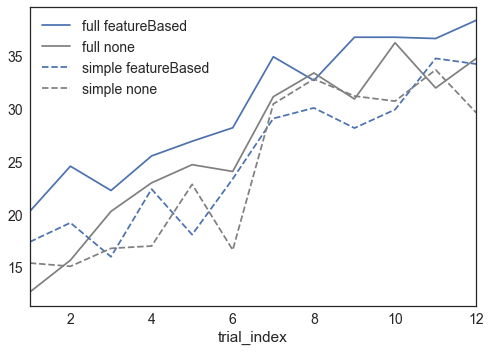

In [8]:
# dd = df.set_index('trial_index')
def plot():
    ax = plt.gca()
    c = {'none': 'gray', 'featureBased': 'b'}
    ls = {'simple': '--', 'full': '-'}
    dd = df.groupby(['message', 'PR_type', 'trial_index']).score.mean()
    for (m, p), dd in df.groupby(['message', 'PR_type']):
        dd.groupby('trial_index').score.mean().plot(
            ax=ax, c=c[p], ls=ls[m], label='{} {}'.format(m, p))
    plt.legend()
plot()


In [89]:
sns.lmplot('trial_index', 'relative_score', hue='PR_type', data=df,
               col='info_cost', size=4, sharey=False, lowess=True, scatter=0,
               hue_order=PR_ORDER, palette=PALETTE)

NameError: name 'PR_ORDER' is not defined

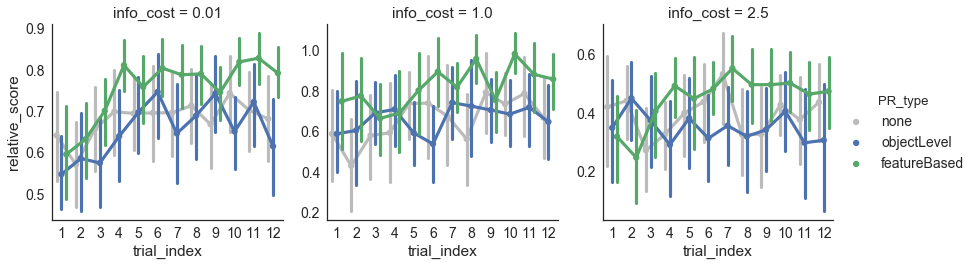

In [27]:
sns.factorplot('trial_index', 'relative_score', hue='PR_type', data=df,
               col='info_cost', size=4, sharey=False,
               dodge=.5, markers='.', ci=95, estimator=np.mean,
               hue_order=PR_ORDER, palette=PALETTE)

In [11]:
cols = [
    'info_cost',
    'relative_score',
    'trial_index',
    'score',
    'n_click',
    'pid',
    'trial_i',
    'PR_type',
    'test',
    'message'
]
rdf = df2r(df, cols)

KeyError: "['relative_score'] not in index"

In [178]:
%%R -i rdf
require(lme4)
require(car)
require(lsmeans)
# rdf$info_cost = as.factor(rdf$info_cost)
m = Anova(lmer('score ~ trial_index * PR_type * message + (1|pid) + (1|trial_i)', 
          data=rdf,
           # data=subset(rdf, info_cost == .01)
                      ))
m

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                              Chisq Df Pr(>Chisq)    
trial_index                 39.4779  1  3.318e-10 ***
PR_type                      4.5890  1   0.032178 *  
message                      9.5945  1   0.001952 ** 
trial_index:PR_type          1.3766  1   0.240677    
trial_index:message          0.0483  1   0.826118    
PR_type:message              1.7674  1   0.183701    
trial_index:PR_type:message  0.0122  1   0.911898    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [10]:
%%R -i rdf
Anova(lm
      ('score ~ condition', 
           data=subset(rdf, trial_index == 1)
                      ))

NameError: name 'rdf' is not defined

In [222]:
pdf.groupby('condition')[['PR_type', 'message']].apply(lambda x: x.iloc[0])

,PR_type,message
condition,,
0,none,full
1,none,simple
2,featureBased,full
3,featureBased,simple


In [217]:
%%R -i rdf
Anova(lm
      ('score ~ message * PR_type', 
           data=subset(rdf, trial_index == 1)
                      ))

Anova Table (Type II tests)

Response: score
                Sum Sq  Df F value  Pr(>F)  
message             35   1  0.0936 0.75997  
PR_type           1015   1  2.7350 0.09983 .
message:PR_type    344   1  0.9259 0.33715  
Residuals        70133 189                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [206]:
df.query('trial_index == 1').groupby('condition').n_click.mean()

condition
constant_full      3.80
constant_simple    7.75
pseudo_full        4.50
pseudo_simple      3.00
Name: n_click, dtype: float64

In [198]:
%%R
print('no feedback')
m = Anova(lmer('score ~ PR_type * message + (1|pid) + (1|trial_i)', 
#           data=rdf,
           data=subset(rdf, test==1)
                      ))
print(m)
print('feedback')
m = Anova(lmer('score ~ PR_type * message + (1|pid) + (1|trial_i)', 
#           data=rdf,
           data=subset(rdf, test==0)
                      ))
print(m)

[1] "no feedback"
Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                 Chisq Df Pr(>Chisq)  
PR_type         1.2818  1    0.25757  
message         6.4725  1    0.01096 *
PR_type:message 2.0792  1    0.14932  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "feedback"
Analysis of Deviance Table (Type II Wald chisquare tests)

Response: score
                 Chisq Df Pr(>Chisq)   
PR_type         6.1773  1   0.012940 * 
message         7.9385  1   0.004839 **
PR_type:message 0.8277  1   0.362949   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [382]:
# from pymc3 import *

# with Model():
#     glm.GLM.from_formula('score ~ PR_type * trial_index', data=df)
#     start = find_MAP()
#     step = NUTS(scaling=start)
#     trace = sample(2000, step)
    

# full = t['PR_type[T.fullObservation]']
# none = t['PR_type[T.none]']
# (none > 0).mean()

Optimization terminated successfully.
         Current function value: 2314.381831

/usr/local/lib/miniconda3/lib/python3.5/site-packages/pymc3/sampling.py:163: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically initialized. init argument ignored.')
  4%|▍         | 82/2000 [00:00<00:11, 173.13it/s]


         Iterations: 47
         Function evaluations: 55
         Gradient evaluations: 55
